<Axes: >

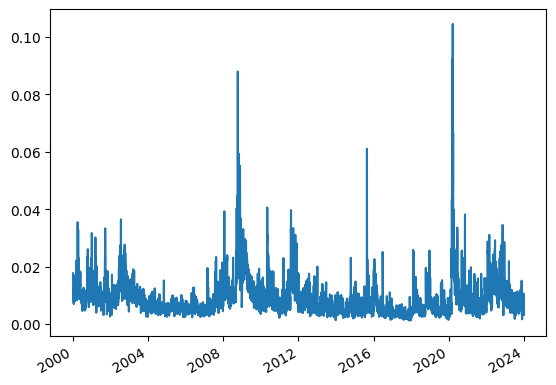

In [4]:
daily_data['rv5'].plot()

In [5]:
daily_data['return'].mean()

0.00019865683979876763

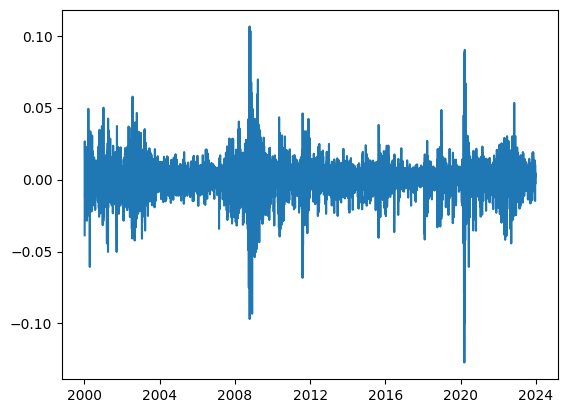

In [6]:
# plot the returns
plt.plot(daily_data['return'])

In [7]:
daily_data.describe()

,rv5,return
count,6021.000000,6021.000000
mean,0.008779,0.000199
std,0.006518,0.012301
min,0.001104,-0.127089
25%,0.004890,-0.004764
50%,0.007133,0.000581
75%,0.010531,0.005954
max,0.104590,0.106420


LSTM vs VAR

Data Analysis and Visualization

<Axes: >

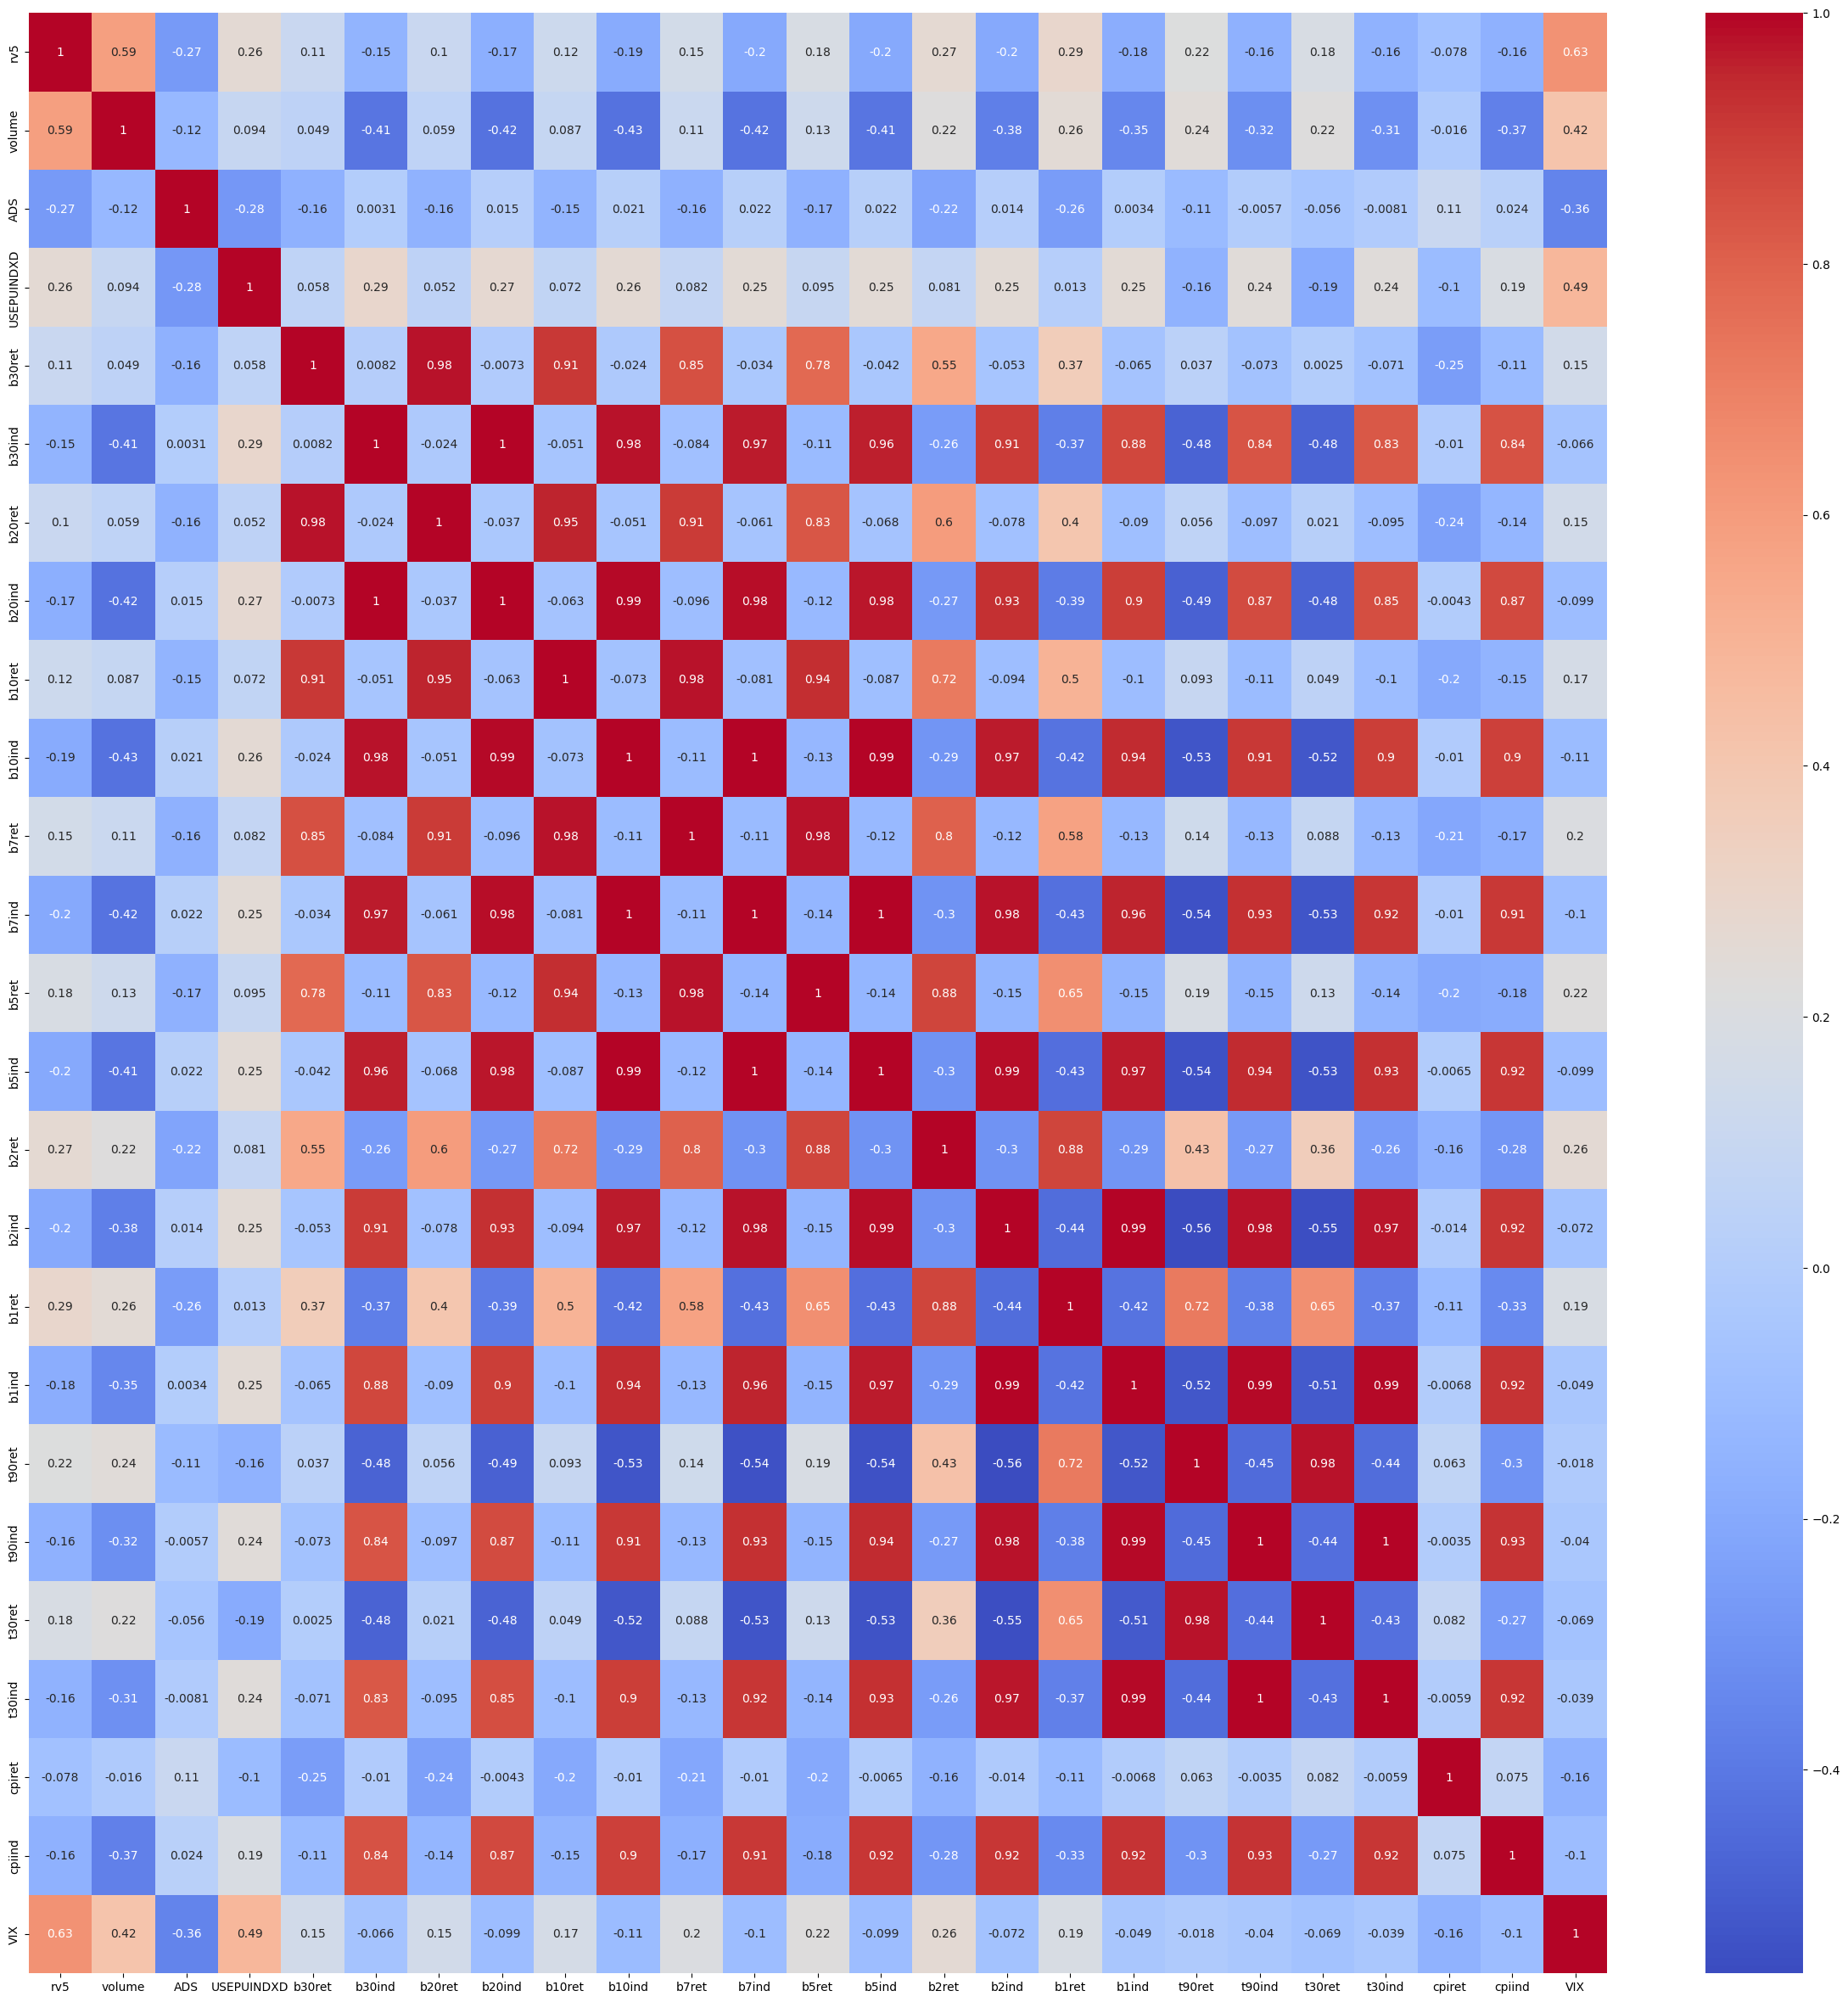

In [101]:
plt.figure(figsize=(30,30))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

In [119]:
import pandas as pd
import networkx as nx

# Assuming 'data' is your DataFrame
correlation_matrix = data.corr()

# Create a graph from the correlation matrix
graph = nx.Graph()
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            graph.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

# Find all cliques in the graph
cliques = list(nx.find_cliques(graph))

# Find the largest clique
largest_clique = max(cliques, key=len)

print(f"The largest group of columns where each pair has a correlation above 0.8 is: {largest_clique}")

The largest group of columns where each pair has a correlation above 0.8 is: ['b5ind', 'b30ind', 'b10ind', 'b20ind', 't90ind', 'cpiind', 'b2ind', 'b7ind', 't30ind', 'b1ind']


In [ ]:
#TODO: Data Augmentation

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming 'data' is your DataFrame
X = data.drop('rv5', axis=1)
y = data['rv5']

# Perform backward elimination
cols = list(X.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index=cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if (pmax > 0.05):
        cols.remove(feature_with_p_max)
        print("The feature removed is: ", feature_with_p_max)
    else:
        break

selected_features_BE = cols
print("The significant features after backward elimination are: ", selected_features_BE)
selected_features_BE += ['rv5']
data_selected = data[selected_features_BE]



LSTM Model

In [ ]:
#TODO: adding the lags of the variables to LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming 'data_selected' is your DataFrame and 'rv5' is the column you want to predict
data = data_selected['rv5'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Create a time series dataset
X, y = [], []
for i in range(1, len(data)):
    X.append(data[i - 1:i, 0])
    y.append(data[i, 0])
X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to fit the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


model = LSTMModel(1, 50)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
hist = np.zeros(50)
for t in range(50):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

# Make predictions
y_train_pred = model(X_train)
y_test_pred = model(X_test)

# Invert the predictions back to the original scale
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy().reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy().reshape(-1, 1))

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train RMSE: {train_rmse}')
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test RMSE: {test_rmse}')
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f'Train MAE: {train_mae}')
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f'Test MAE: {test_mae}')

# Plot actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.legend()
plt.show()

# Plot the training error with each epoch
plt.figure(figsize=(12, 6))
plt.plot(hist, label='Train Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()